# Copernicus Sentinel-5P TROPOMI - Ultraviolet Aerosol Index - Level 2

```{hint} 
<a href='https://fire.ltpy.adamplatform.eu/hub/user-redirect/lab/tree/ca_part2_workflows/figure2_Sentinel-5P_TROPOMI_L2_UVAI.ipynb' target='_blank'>Execute the notebook on the training platform >></a>
```

The Copernicus [Sentinel-5 Ultraviolet Visible Near-Infrared Shortwave (UVNS) spectrometer](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5) enables the measurement of trace gases which will improve air quality forecasts produced by the Copernicus Atmosphere Monitoring service.

This notebook provides you an introduction to data from [Sentinel-5P](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p), the precursor instrument and proxy for data from [Sentinel-5](https://www.eumetsat.int/sentinel-5). Sentinel-5P data can be downloaded from the [Sentinel-5P Pre-Operations Data Hub](https://s5phub.copernicus.eu/dhus/#/home).

The event featured is the [August Complex fire](https://www.fire.ca.gov/incidents/2020/8/16/august-complex-includes-doe-fire/) in California, USA in 2020. This was the largest wildfire in CA history, spreading over 1,000,000 acres (over 4,000 sq km). The image shown in this notebook is taken from 11 September 2020.

For monitoring smoke, the `TROPOMI UV Aerosol Index (UVAI)` data can be used. Positive values of UVAI (typically > about 1.0) indicate the presence of absorbing-type aerosols: 
- `smoke from forest fires`, 
- `volcanic ash`, or 
- `desert dust`. 


```{admonition} Basic Facts
**Spatial resolution**: `Up to 5.5* km x 3.5 km` (5.5 km in the satellite flight direction and 3.5 km in the perpendicular direction at nadir) <br>
**Spatial coverage**: `Global` <br>
**Revisit time**:  `less than one day` <br>
**Data availability**: `since April 2018`
```

```{admonition} How to access the data
Sentinel-5P Pre-Ops data are disseminated in the `netCDF` format and can be downloaded via the <a href='https://dataspace.copernicus.eu/' target='_blank'>Copernicus Open Access Hub</a>. You need to register for an account before downloading data. 
```

<hr>

**Load required libraries**

In [1]:
import os
import xarray as xr
from datetime import datetime
import numpy as np
from netCDF4 import Dataset
import pandas as pd

# Python libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
from matplotlib.axes import Axes
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from skimage import exposure

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

**Load helper functions**

In [11]:
%run ../functions.ipynb

<hr>

## Load and browse Sentinel-5P TROPOMI Aerosol Index Level 2 data

A Sentinel-5P TROPOMI Aerosol Index Level 2 file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5P TROPOMI variables have the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index

Sentinel-5P TROPOMI data is disseminated in `netCDF`. You can load several `netCDF` files with the `open_mfdataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5P data files, you have to specify the following keyword arguments: 
- `group='PRODUCT'`: to load the `PRODUCT` group

You can load all the datasets available for one day into one xarray object by using `scanline` as concatanation dimension.

In [6]:
s5p_mf = xr.open_mfdataset('../data/sentinel-5p/uvai/2020/09/11/*.nc', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p_mf


<xarray.Dataset>
Dimensions:                          (scanline: 12079, ground_pixel: 450, time: 1, corner: 4)
Coordinates:
  * scanline                         (scanline) float64 0.0 1.0 ... 3.734e+03
  * ground_pixel                     (ground_pixel) float64 0.0 1.0 ... 449.0
  * time                             (time) datetime64[ns] 2020-09-11
  * corner                           (corner) float64 0.0 1.0 2.0 3.0
    latitude                         (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 450), meta=np.ndarray>
    longitude                        (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 450), meta=np.ndarray>
Data variables:
    delta_time                       (time, scanline) datetime64[ns] dask.array<chunksize=(1, 4172), meta=np.ndarray>
    time_utc                         (time, scanline) object dask.array<chunksize=(1, 4172), meta=np.ndarray>
    qa_value                         (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 450), meta=np.ndarray>
    aerosol_index_354_388            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 450), meta=np.ndarray>
    aerosol_index_340_380            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 450), meta=np.ndarray>
    aerosol_index_354_388_precision  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 450), meta=np.ndarray>
    aerosol_index_340_380_precision  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 450), meta=np.ndarray>

You see that the loaded data object contains of four dimensions and seven data variables:
* **Dimensions**:
  * `scanline` 
  * `ground_pixel`
  * `time`
  * `corner`


* **Data variables**:
  * `delta_time`: the offset of individual measurements within the granule, given in milliseconds
  * `time_utc`: valid time stamp of the data
  * `qa_value`: quality descriptor, varying between 0 (nodata) and 1 (full quality data).
  * `aerosol_index_354_388`: Aerosol index from 354 and 388 nm
  * `aerosol_index_340_380`: Aerosol index from 340 and 380 nm
  * `aerosol_index_354_388_precision`: Precision of aerosol index from 354 and 388 nm
  * `aerosol_index_340_380_precision`: Precision of aerosol index from 340 and 380 nm

## Retrieve the variable 'Aerosol index from 340 and 380 nm' as xarray.DataArray

You can specify one variable of interest by putting the name of the variable into square brackets `[]` and get more detailed information about the variable. E.g. `aerosol_index_340_380` is the 'Aerosol index from 340 and 380 nm' and has three dimensions, `time`, `scanline` and `ground_pixel` respectively.

In [13]:
uvai = s5p_mf.aerosol_index_340_380[0,:,:]
uvai

<xarray.DataArray 'aerosol_index_340_380' (scanline: 12079, ground_pixel: 450)>
dask.array<getitem, shape=(12079, 450), dtype=float32, chunksize=(4172, 450), chunktype=numpy.ndarray>
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 3.733e+03 3.734e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2020-09-11
    latitude      (scanline, ground_pixel) float32 dask.array<chunksize=(4172, 450), meta=np.ndarray>
    longitude     (scanline, ground_pixel) float32 dask.array<chunksize=(4172, 450), meta=np.ndarray>
Attributes:
    units:                   1
    proposed_standard_name:  ultraviolet_aerosol_index
    comment:                 Aerosol index from 380 and 340 nm
    long_name:               Aerosol index from 380 and 340 nm
    radiation_wavelength:    [340. 380.]
    ancillary_variables:     aerosol_index_340_380_precision

## Create a geographical subset for California, USA

You can zoom into a region by specifying a `bounding box` of interest. Let us set the extent to California with the following bounding box information:

In [14]:
latmin=10.
latmax=80.
lonmin=-170.
lonmax=-80.

Now, let us apply the function [](functions:generate_geographical_subset) to subset the `uvai` xarray.DataArray. Let us call the new `xarray.DataArray` `uvai`.

In [15]:
uvai_subset = generate_geographical_subset(xarray=uvai, 
                                             latmin=latmin, 
                                             latmax=latmax, 
                                             lonmin=lonmin, 
                                             lonmax=lonmax)
uvai_subset

<xarray.DataArray 'aerosol_index_340_380' (scanline: 4550, ground_pixel: 450)>
dask.array<where, shape=(4550, 450), dtype=float32, chunksize=(1582, 450), chunktype=numpy.ndarray>
Coordinates:
  * scanline      (scanline) float64 2.101e+03 2.102e+03 ... 3.559e+03 3.56e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
    time          datetime64[ns] 2020-09-11
    latitude      (scanline, ground_pixel) float32 dask.array<chunksize=(1582, 450), meta=np.ndarray>
    longitude     (scanline, ground_pixel) float32 dask.array<chunksize=(1582, 450), meta=np.ndarray>
Attributes:
    units:                   1
    proposed_standard_name:  ultraviolet_aerosol_index
    comment:                 Aerosol index from 380 and 340 nm
    long_name:               Aerosol index from 380 and 340 nm
    radiation_wavelength:    [340. 380.]
    ancillary_variables:     aerosol_index_340_380_precision

You can extract the latitude and longitude information from the subsetted data and save them into new variables for plotting later.

In [16]:
lat = uvai_subset.latitude
lon = uvai_subset.longitude


## Visualize Sentinel-5P TROPOMI 'Aerosol Index from 340 and 350 nm'

The next step is to visualize the dataset. You can use the function [](functions:visualize_pcolormesh), which makes use of matploblib's function `pcolormesh` and the [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) library.

With `?visualize_pcolormesh` you can open the function's docstring to see what keyword arguments are needed to prepare your plot.

In [17]:
?visualize_pcolormesh

Signature:
visualize_pcolormesh(
    data_array,
    longitude,
    latitude,
    projection,
    color_scale,
    unit,
    long_name,
    vmin,
    vmax,
    set_global=True,
    lonmin=-180,
    lonmax=180,
    latmin=-90,
    latmax=90,
)
Docstring:
Visualizes a xarray.DataArray with matplotlib's pcolormesh function.

Parameters:
    data_array(xarray.DataArray): xarray.DataArray holding the data values
    longitude(xarray.DataArray): xarray.DataArray holding the longitude values
    latitude(xarray.DataArray): xarray.DataArray holding the latitude values
    projection(str): a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
    color_scale(str): string taken from matplotlib's color ramp reference
    unit(str): the unit of the parameter, taken from the NetCDF file if possible
    long_name(str): long name of the parameter, taken from the NetCDF file if possible
    vmin(int): minimum number on visualisation legend
    vmax(int): maximum number on visualisation

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Aerosol index from 380 and 340 nm - 2020-09-11'}>)

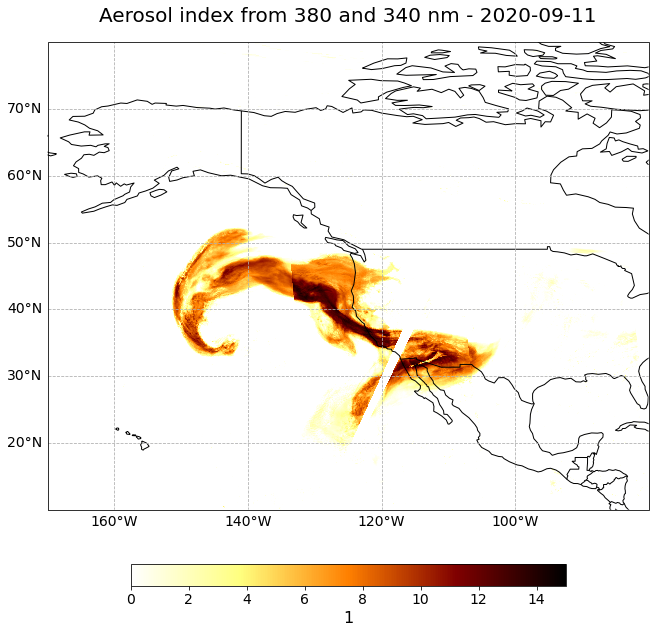

In [18]:
visualize_pcolormesh(data_array=uvai_subset,
                     longitude=lon, 
                     latitude=lat, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='afmhot_r', 
                     unit=uvai.units, 
                     long_name=uvai.long_name + ' - ' + str(uvai.time.data)[0:10], 
                     vmin=0, 
                     vmax=15, 
                     lonmin=lonmin, 
                     lonmax=lonmax, 
                     latmin=latmin, 
                     latmax=latmax, 
                     set_global=False)


<hr>

### References

* Copernicus Sentinel data 2020

* Some code in this notebook was adapted from the following sources:
  * origin: https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/242_Sentinel-5P_TROPOMI_UVAI_L2_load_browse.ipynb
  * copyright: 2022, EUMETSAT
  * license: MIT
  * retrieved: 2022-06-28 by Sabrina Szeto

```{admonition} Return to the case study
Monitoring smoke transport with next-generation satellites from Metop-SG: Californian Wildfires Case Study<br>
[](ca_part2_fig2)
```